# Imports

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import pearsonr

# Load Dataset

In [3]:
df = pd.read_csv("../dataset/TikTokEuropeanElections_Abortion_War.csv")

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1504 entries, 0 to 1503
Data columns (total 57 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                1504 non-null   int64  
 1   experiments               1504 non-null   object 
 2   total_experiments         1504 non-null   int64  
 3   total_samples             1504 non-null   int64  
 4   interface                 1504 non-null   object 
 5   countries                 1504 non-null   object 
 6   languages                 1504 non-null   object 
 7   search_queries            1504 non-null   object 
 8   video_id                  1504 non-null   int64  
 9   video_title               1504 non-null   object 
 10  video_url                 1504 non-null   object 
 11  video_link                1504 non-null   object 
 12  description               1504 non-null   object 
 13  creator_id                1504 non-null   object 
 14  creator_

# Sentiment Score By Country

## General Study

- **Mean General Sentiment Score Compound** 

Bootstrapped 95% CI for 'sentiment_score': [0.178, 0.253]


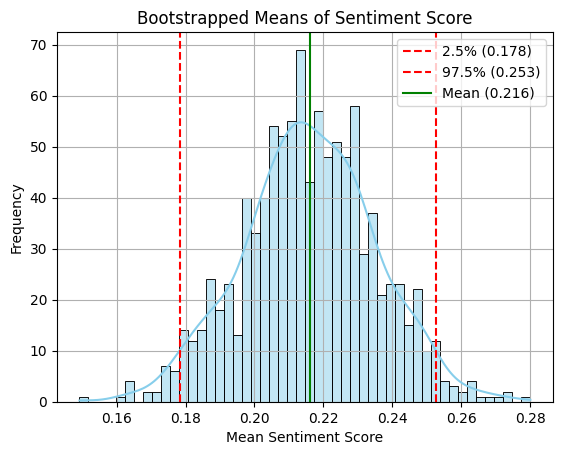

In [4]:
# Defining the hyperparameters
n_iterations = 1000
sample_size = len(df)
boot_means = []

# Bootstrapping loop
for i in range(n_iterations):
    sample = df.sample(n=sample_size, replace=True)
    mean = sample['sentiment_score_compound'].mean()
    boot_means.append(mean)

# Calculating confidence interval
ci_lower = np.percentile(boot_means, 2.5)
ci_upper = np.percentile(boot_means, 97.5)

# The mean of the whole population is between this two points
print(f"Bootstrapped 95% CI for 'sentiment_score': [{ci_lower:.3f}, {ci_upper:.3f}]")

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(boot_means, bins=50, kde=True, color='skyblue')
plt.axvline(ci_lower, color='red', linestyle='--', label=f'2.5% ({ci_lower:.3f})')
plt.axvline(ci_upper, color='red', linestyle='--', label=f'97.5% ({ci_upper:.3f})')
plt.axvline(np.mean(boot_means), color='green', linestyle='-', label=f'Mean ({np.mean(boot_means):.3f})')
plt.title("Bootstrapped Means of Sentiment Score")
plt.xlabel("Mean Sentiment Score")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


- **Count the amount of entries per country**

In [5]:
country_counts = df['countries'].value_counts()
print(country_counts)

countries
{'nl'}    334
{'de'}    327
{'es'}    323
{'fr'}    262
{'pl'}    258
Name: count, dtype: int64


- **Bootstrapped mean for compound sentiment score by country**

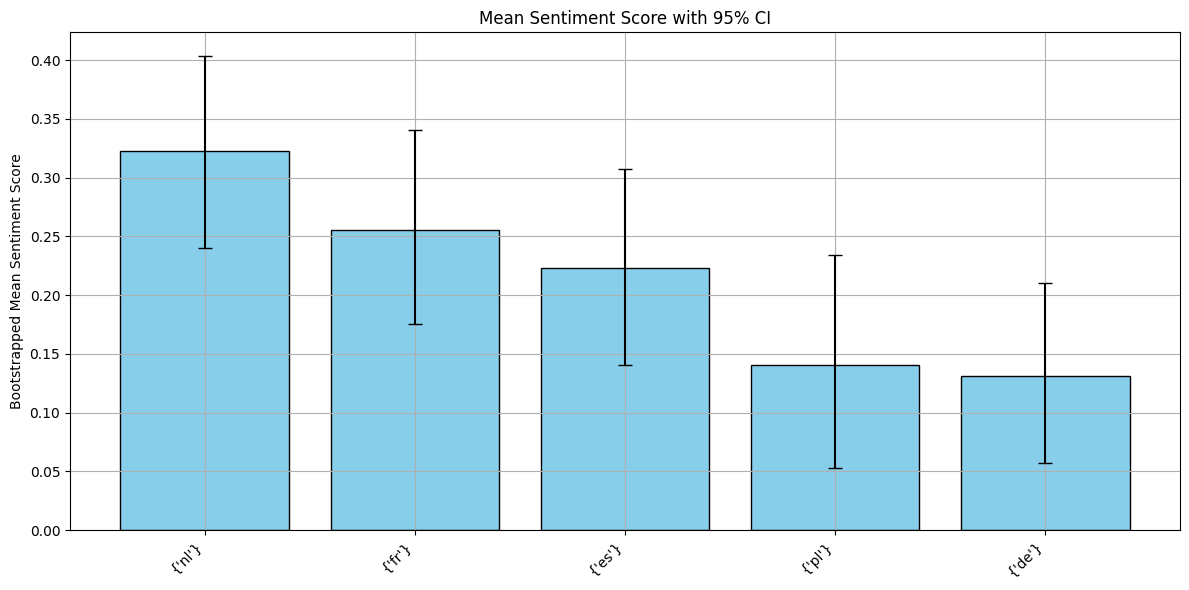

In [6]:
# Parameters
n_iterations = 1000
boot_data = []

# Group by 'countries'
for country, group in df.groupby('countries'):
    scores = group['sentiment_score_compound'].dropna()
    
    means = []
    for _ in range(n_iterations):
        sample = scores.sample(n=len(scores), replace=True)
        means.append(sample.mean())
    
    ci_lower = np.percentile(means, 2.5)
    ci_upper = np.percentile(means, 97.5)
    boot_data.append({
        'country': country,
        'mean': np.mean(means),
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    })

# Convert to DataFrame
boot_df = pd.DataFrame(boot_data)
boot_df.sort_values(by='mean', ascending=False, inplace=True)

# Plot
plot = boot_df.head(15)
plt.figure(figsize=(12, 6))
plt.bar(plot['country'], plot['mean'], yerr=[plot['mean'] - plot['ci_lower'], plot['ci_upper'] - plot['mean']],
        capsize=5, color='skyblue', edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Bootstrapped Mean Sentiment Score')
plt.title('Mean Sentiment Score with 95% CI')
plt.tight_layout()
plt.grid(True)
plt.show()


- **Compound sentiment score distribution by country**

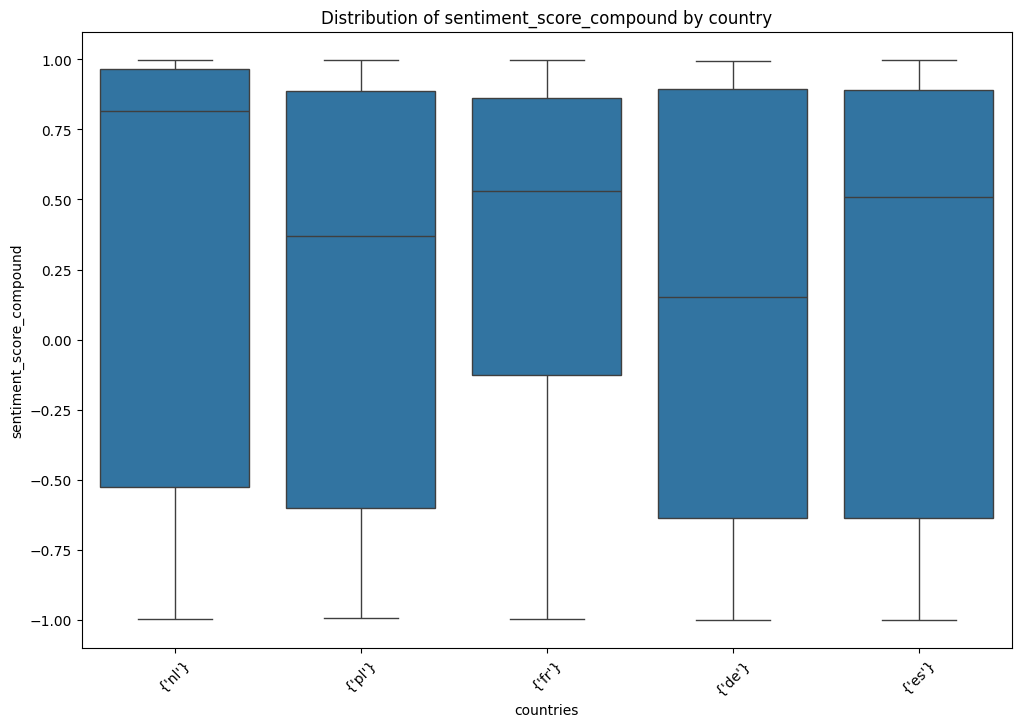

In [7]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='countries', y='sentiment_score_compound')
plt.xticks(rotation=45)
plt.title('Distribution of sentiment_score_compound by country')
plt.show()

- **Amount of Pos and Neg entries given the Binary Sentiment Score classification**

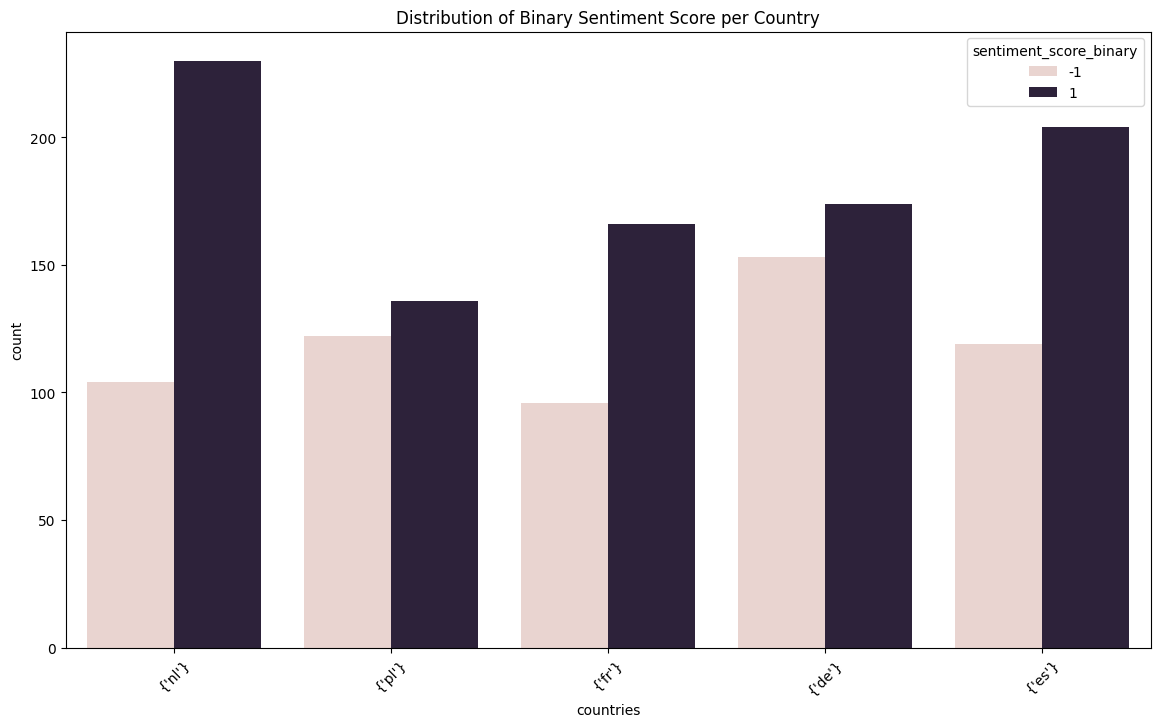

In [8]:
plt.figure(figsize=(14, 8))
sns.countplot(data=df, x='countries', hue='sentiment_score_binary')
plt.xticks(rotation=45)
plt.title('Distribution of Binary Sentiment Score per Country')
plt.show()

- **Ration Betweenn Pos and Neg entries per country**

In [9]:
counts = df.groupby(['countries', 'sentiment_score_binary']).size().unstack(fill_value=0)

counts['pos_neg_ratio'] = counts.get(1, 0) / counts.get(-1, 1)

print(counts[['pos_neg_ratio']])


sentiment_score_binary  pos_neg_ratio
countries                            
{'de'}                       1.137255
{'es'}                       1.714286
{'fr'}                       1.729167
{'nl'}                       2.211538
{'pl'}                       1.114754


- **Histogram of the sentiment score compound to see the entries intensity**

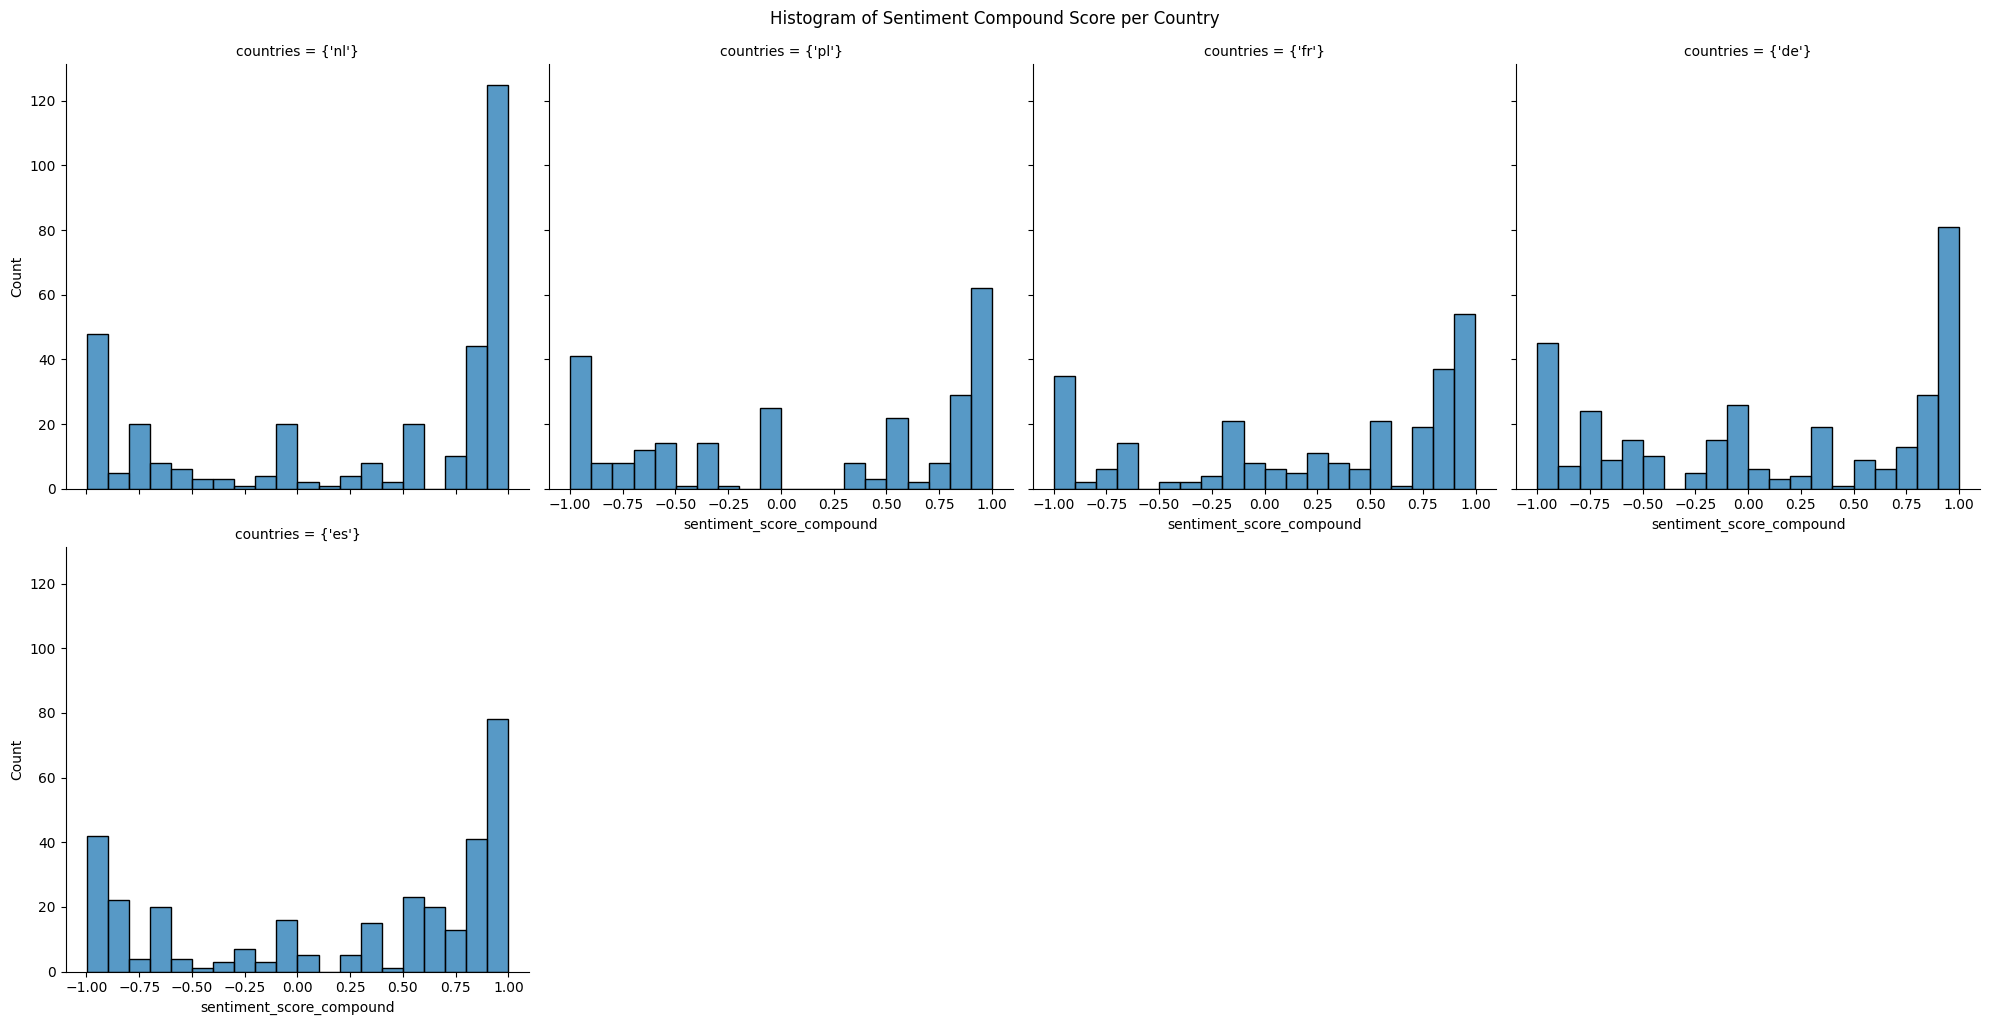

In [10]:
plot = sns.displot(df, x="sentiment_score_compound", col="countries", col_wrap=4, bins=20, kde=False, facet_kws={'sharex': True, 'sharey': True})
plot.fig.suptitle('Histogram of Sentiment Compound Score per Country', y=1.02)
plt.show()

In [15]:
total_counts = df['countries'].value_counts()
extreme_df = df[(df['sentiment_score_compound'] > 0.75) | (df['sentiment_score_compound'] < -0.75)]
extreme_counts = extreme_df['countries'].value_counts()
extreme_ratios = (extreme_counts / total_counts).fillna(0)
extreme_ratios = extreme_ratios.sort_values(ascending=False)
print(extreme_ratios)

countries
{'nl'}    0.715569
{'es'}    0.603715
{'pl'}    0.596899
{'fr'}    0.553435
{'de'}    0.550459
Name: count, dtype: float64


- **Conclusions of this part**

- **NL**:

    - Intensity of sentiment score: Bimodal distribution with an enormous value on 1. Polarization towards positive content.
    - Positive/negative ratio: Extremly high (2.2), makes sense with the fact that most of entries are on 1.
    - Boxplot: Enormous median (~0.85) with a hight range.
    - Polarization:very high (0.77)

- **FR**:

    - Intensity of sentiment score: Splitted entries, while there is a majority of positive values the emotions aren't extreme.
    - Positive/negative ratio: High value (1.7) but reflect that there is more variety of emotions that on NL.
    - Boxplot: High median (~0.5) since there is more positive content but not as extreme as in NL.
    - Polarization: Average (0.55)

- **ES**:

    - Intensity of sentiment score: Very polarized results, while positive content is nearly the double of the negative, most of the entries are on the extremes.
    - Positive/negative ratio: High value (1.7) but reflect that there is more variety of extreme emotions that on NL.
    - Boxplot: High median (~0.5) since there is more extreme content, both in negative and positive.
    - Polarization: Average-High (0.6)

- **PL**:

    - Intensity of sentiment score: Bimodal but with more splitted results.
    - Positive/negative ratio: Very low value (1.11) due to the fact that most of the neutral content is slightly negative.
    - Boxplot: High median (~0.4) showing a more symetric range showcasing the higher amount of neutral content.
    - Polarization: Average-High (0.59)

- **DE**:

    - Intensity of sentiment score: High amount of negative content of all intesities and positive content centralized on the positive extreme.
    - Positive/negative ratio: Low value (1.14) since there are only extremly positive contents and an enormous amount of negative contents of all intensities.
    - Boxplot: High median (~0.2) showcasing the fact that there is a lot of negative content and very dispersed entries.
    - Polarization: Average (0.55)

## Study by topic

- **Mean sentiment score compound by topic**

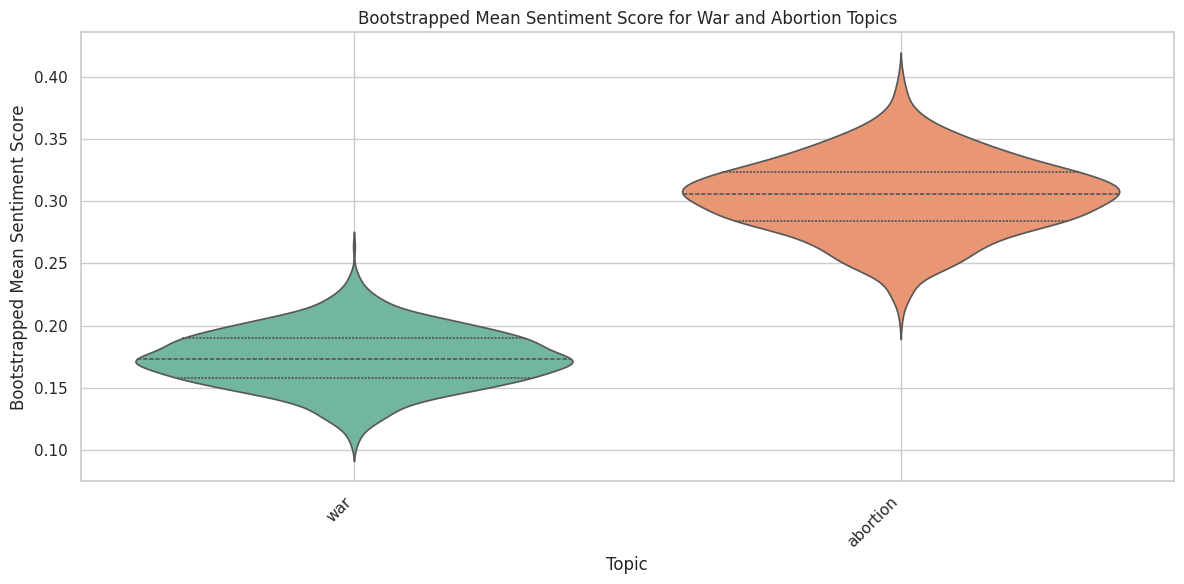

In [16]:
# Parameters
n_iterations = 1000
boot_results = []

# Group by topic and run bootstrapping for war and abortion
topics_of_interest = ['war', 'abortion']
topic_boot_means = {}

for topic in topics_of_interest:
    group = df[df['topic'].str.lower() == topic]  # Filter for war or abortion
    scores = group['sentiment_score_compound'].dropna()
    
    boot_means = []
    for _ in range(n_iterations):
        # Bootstrap sampling with replacement
        sample = scores.sample(n=len(scores), replace=True)
        boot_means.append(sample.mean())
    
    topic_boot_means[topic] = boot_means

# Convert to DataFrame for easier analysis
boot_df = pd.DataFrame(topic_boot_means)

# Plot the distributions of bootstrapped means for both topics
plt.figure(figsize=(12, 6))
sns.violinplot(data=boot_df, palette='Set2', inner='quartile')
plt.title("Bootstrapped Mean Sentiment Score for War and Abortion Topics")
plt.xlabel("Topic")
plt.ylabel("Bootstrapped Mean Sentiment Score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
plt.show()

- **Histogram of the sentiment score compound per topic**

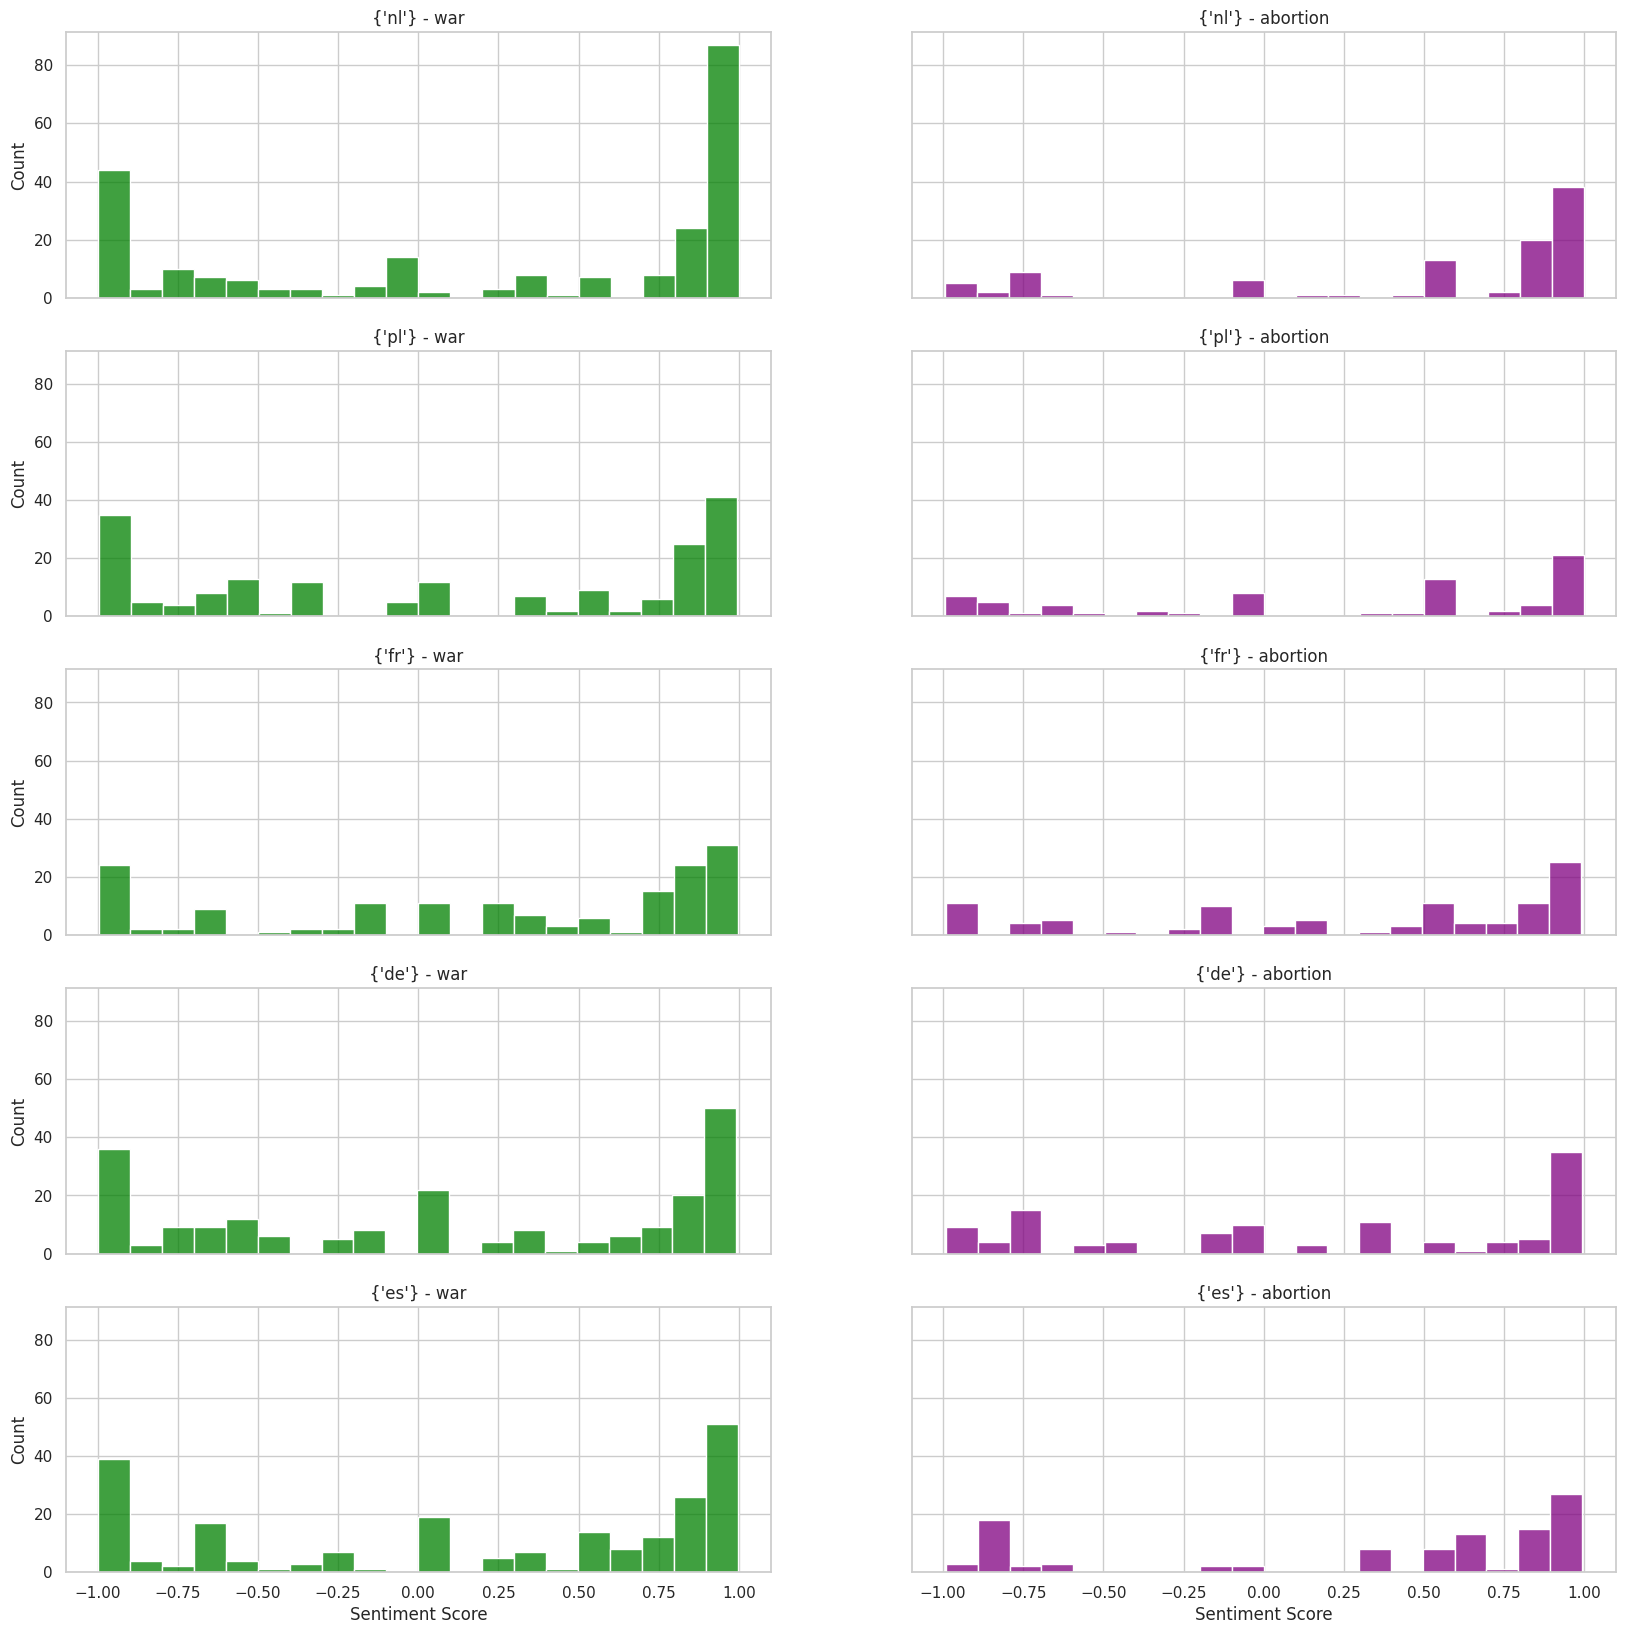

In [17]:
topic_colors = {
    'abortion': 'purple',
    'war': 'green'
}

# Get countries and topics
countries = df['countries'].unique()
topics = df['topic'].unique()

# Create subplots
n_rows = len(countries)
n_cols = len(topics)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20), sharex=True, sharey=True)

# Iterate through countries and topics
for i, country in enumerate(countries):
    for j, topic in enumerate(topics):

        subset = df[(df['countries'] == country) & (df['topic'] == topic)]
        ax = axes[i][j]    
        color = topic_colors.get(topic)
        sns.histplot(data=subset, x='sentiment_score_compound', bins=20, kde=False, ax=ax, color=color)

        ax.set_title(f"{country} - {topic}")
        ax.set_xlabel('Sentiment Score')
        ax.set_ylabel('Count')

sns.set(style="whitegrid")
plt.show()

- **% of extreme sentiment entries (1, -1) per country and topic**

In [18]:
# Compute total entries per country and topic
total_counts = df.groupby(['countries', 'topic']).size().reset_index(name='total_count')

# Compute strong positive entries (≥ 0.75)
strong_pos = df[df['sentiment_score_compound'] >= 0.75]
pos_counts = strong_pos.groupby(['countries', 'topic']).size().reset_index(name='pos_count')

# Compute strong negative entries (≤ -0.75)
strong_neg = df[df['sentiment_score_compound'] <= -0.75]
neg_counts = strong_neg.groupby(['countries', 'topic']).size().reset_index(name='neg_count')

# Merge all
merged = total_counts.merge(pos_counts, on=['countries', 'topic'], how='left')
merged = merged.merge(neg_counts, on=['countries', 'topic'], how='left')

# Fill NaNs with 0 (for groups that have only pos or only neg)
merged['pos_count'] = merged['pos_count'].fillna(0)
merged['neg_count'] = merged['neg_count'].fillna(0)

# Compute percentages
merged['pos_percent'] = 100 * merged['pos_count'] / merged['total_count']
merged['neg_percent'] = 100 * merged['neg_count'] / merged['total_count']

# Optional: sort by positive or negative percent
merged = merged.sort_values(by='pos_percent', ascending=False)

# Display result
print(merged[['countries', 'topic', 'pos_percent', 'neg_percent']])


  countries     topic  pos_percent  neg_percent
6    {'nl'}  abortion    59.595960    13.131313
7    {'nl'}       war    50.212766    20.851064
5    {'fr'}       war    41.975309    16.049383
2    {'es'}  abortion    41.176471    21.568627
4    {'fr'}  abortion    40.000000    11.000000
3    {'es'}       war    39.366516    19.909502
9    {'pl'}       war    37.967914    23.529412
1    {'de'}       war    37.264151    18.867925
8    {'pl'}  abortion    36.619718    18.309859
0    {'de'}  abortion    36.521739    16.521739


- **Are the extreme sentiments related to the percent of positiveness?**

In [24]:
# Compute extreme sentiment ratio per country (as before)
total_country_counts = df['countries'].value_counts()
extreme_df = df[(df['sentiment_score_compound'] > 0.75) | (df['sentiment_score_compound'] < -0.75)]
extreme_country_counts = extreme_df['countries'].value_counts()
extreme_ratios = (extreme_country_counts / total_country_counts).fillna(0).reset_index()
extreme_ratios.columns = ['countries', 'extreme_ratio']

# Merge the two metrics
relation_df = merged[['countries', 'pos_percent']].merge(extreme_ratios, on='countries', how='inner')

relation_df = relation_df.sort_values(by='extreme_ratio', ascending=False)
print(relation_df)


  countries  pos_percent  extreme_ratio
0    {'nl'}    59.595960       0.715569
1    {'nl'}    50.212766       0.715569
3    {'es'}    41.176471       0.603715
5    {'es'}    39.366516       0.603715
8    {'pl'}    36.619718       0.596899
6    {'pl'}    37.967914       0.596899
4    {'fr'}    40.000000       0.553435
2    {'fr'}    41.975309       0.553435
7    {'de'}    37.264151       0.550459
9    {'de'}    36.521739       0.550459


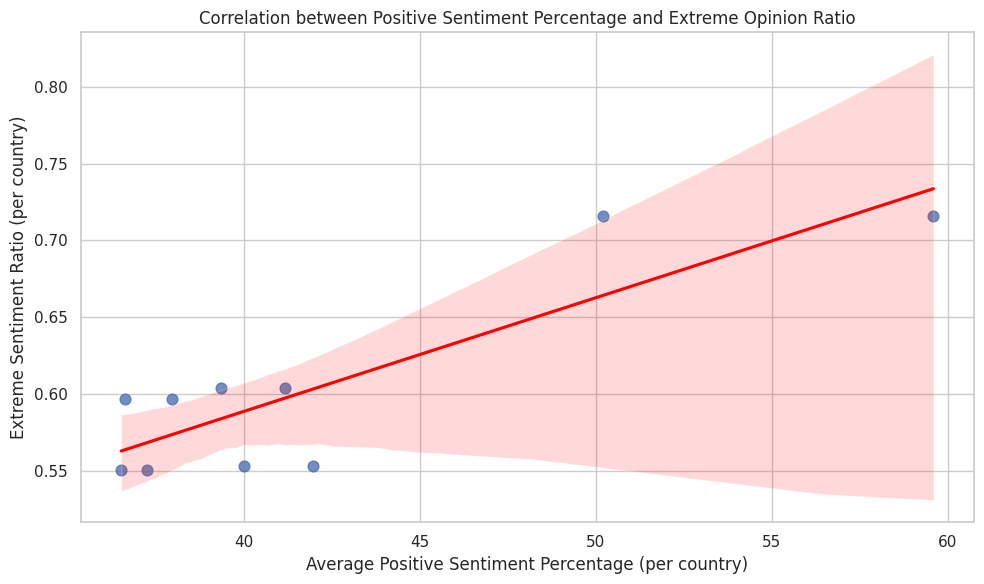

Pearson correlation coefficient: 0.861 (p-value: 0.0014)


In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
sns.regplot(data=relation_df, x='pos_percent', y='extreme_ratio', scatter_kws={'s': 60}, line_kws={'color': 'red'})
plt.title('Correlation between Positive Sentiment Percentage and Extreme Opinion Ratio')
plt.xlabel('Average Positive Sentiment Percentage (per country)')
plt.ylabel('Extreme Sentiment Ratio (per country)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Compute Pearson correlation
corr_coef, p_value = pearsonr(relation_df['pos_percent'], relation_df['extreme_ratio'])
print(f"Pearson correlation coefficient: {corr_coef:.3f} (p-value: {p_value:.4f})")

- **Relating the topics with the intensity of each sentiment**

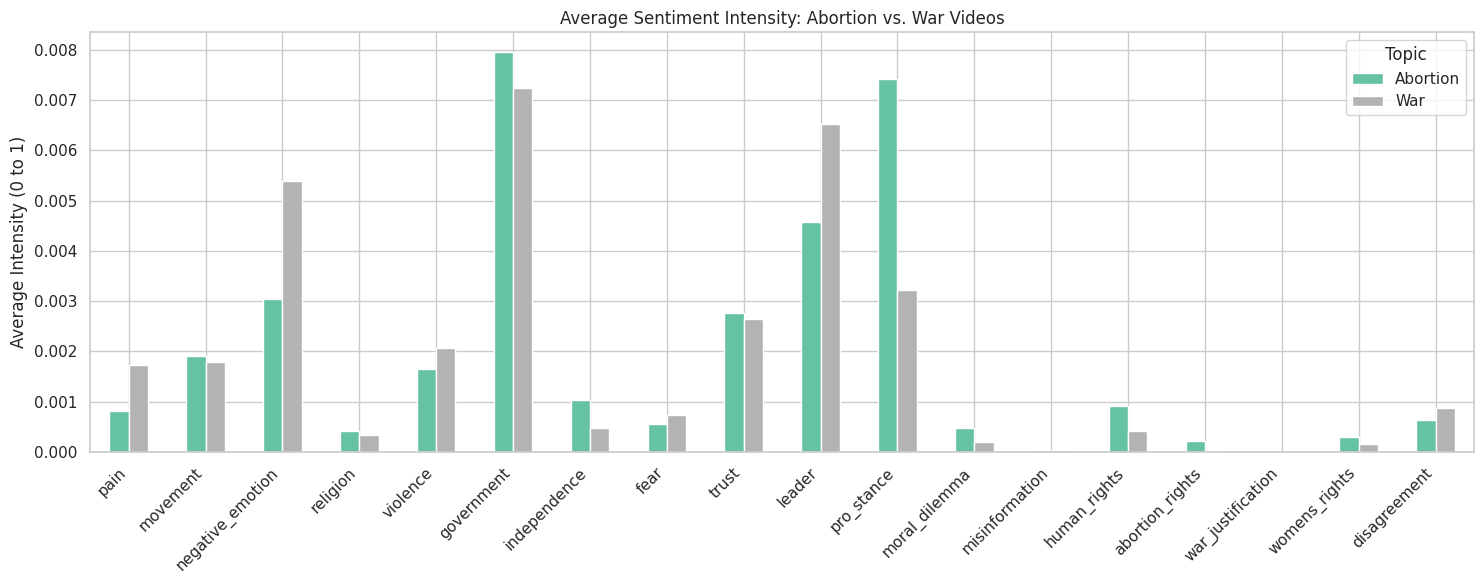

In [26]:
# Define the list of sentiment columns
sentiment = [
    'pain', 'movement', 'negative_emotion', 'religion',
    'violence', 'government', 'independence', 'fear', 'trust', 'leader',
    'pro_stance', 'moral_dilemma', 'misinformation', 'human_rights',
    'abortion_rights', 'war_justification', 'womens_rights', 'disagreement'
]

# Filter for abortion and war topics
abortion_df = df[df['topic'].str.lower().str.contains('abortion')]
war_df = df[df['topic'].str.lower().str.contains('war')]

# Calculate the average intensity for each sentiment
abortion_means = abortion_df[sentiment].mean()
war_means = war_df[sentiment].mean()

# Combine results into a comparison DataFrame
average_intensity_df = pd.DataFrame({
    'Abortion': abortion_means,
    'War': war_means
})

# Plot side-by-side bar chart
average_intensity_df.plot(kind='bar', figsize=(15, 6), colormap='Set2')
plt.title("Average Sentiment Intensity: Abortion vs. War Videos")
plt.ylabel("Average Intensity (0 to 1)")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Topic')
plt.tight_layout()
plt.show()

- **Relating the topics with the amount of times each sentiment appears**

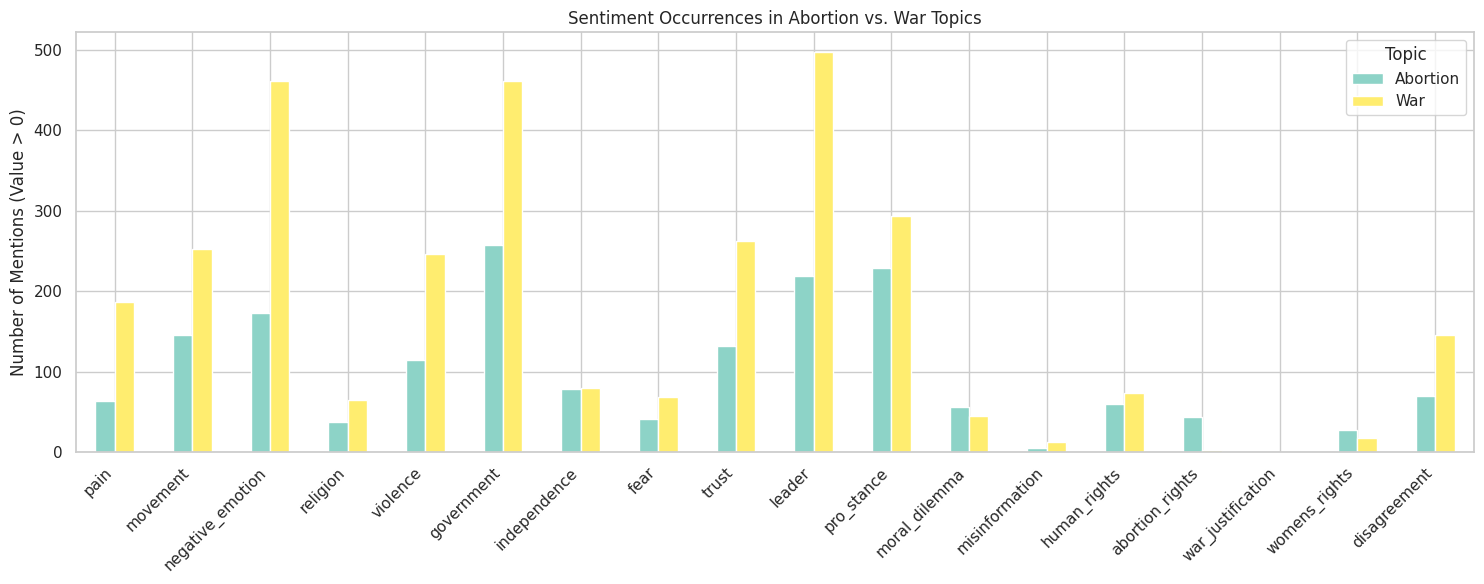

In [27]:
# Define the list of sentiment columns
sentiment = [
    'pain', 'movement', 'negative_emotion', 'religion',
    'violence', 'government', 'independence', 'fear', 'trust', 'leader',
    'pro_stance', 'moral_dilemma', 'misinformation', 'human_rights',
    'abortion_rights', 'war_justification', 'womens_rights', 'disagreement'
]

# Filter for abortion and war topics
abortion_df = df[df['topic'].str.lower().str.contains('abortion')]
war_df = df[df['topic'].str.lower().str.contains('war')]

# Count how many times each sentiment appears (i.e., value > 0)
abortion_counts = (abortion_df[sentiment] > 0).sum()
war_counts = (war_df[sentiment] > 0).sum()

# Combine into a single DataFrame for comparison
sentiment_counts_df = pd.DataFrame({
    'Abortion': abortion_counts,
    'War': war_counts
})

# Plot side-by-side bars
sentiment_counts_df.plot(kind='bar', figsize=(15, 6), colormap='Set3')
plt.title("Sentiment Occurrences in Abortion vs. War Topics")
plt.ylabel("Number of Mentions (Value > 0)")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Topic')
plt.tight_layout()
plt.show()


- **Ratio of appearence of each sentiment**

In [ ]:
# Define the list of sentiment columns
sentiment = [
    'pain', 'movement', 'negative_emotion', 'religion',
    'violence', 'government', 'independence', 'fear', 'trust', 'leader',
    'pro_stance', 'moral_dilemma', 'misinformation', 'human_rights',
    'abortion_rights', 'war_justification', 'womens_rights', 'disagreement'
]

# Filter for abortion and war topics
abortion_df = df[df['topic'].str.lower().str.contains('abortion')]
war_df = df[df['topic'].str.lower().str.contains('war')]

# Get number of entries per topic
abortion_total = len(abortion_df)
war_total = len(war_df)

# Calculate ratio of appearances (value > 0)
abortion_ratios = (abortion_df[sentiment] > 0).sum() / abortion_total
war_ratios = (war_df[sentiment] > 0).sum() / war_total

# Combine into a single DataFrame
sentiment_ratio_df = pd.DataFrame({
    'Abortion': abortion_ratios,
    'War': war_ratios
})

# Plot side-by-side bar chart
sentiment_ratio_df.plot(kind='bar', figsize=(15, 6), colormap='Set2')
plt.title("Ratio of Sentiment Appearance: Abortion vs. War Videos")
plt.ylabel("Proportion of Mentions (0 to 1)")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Topic')
plt.tight_layout()
plt.show()

- **Which sentiments appear the most per country?**

<Figure size 1800x800 with 0 Axes>

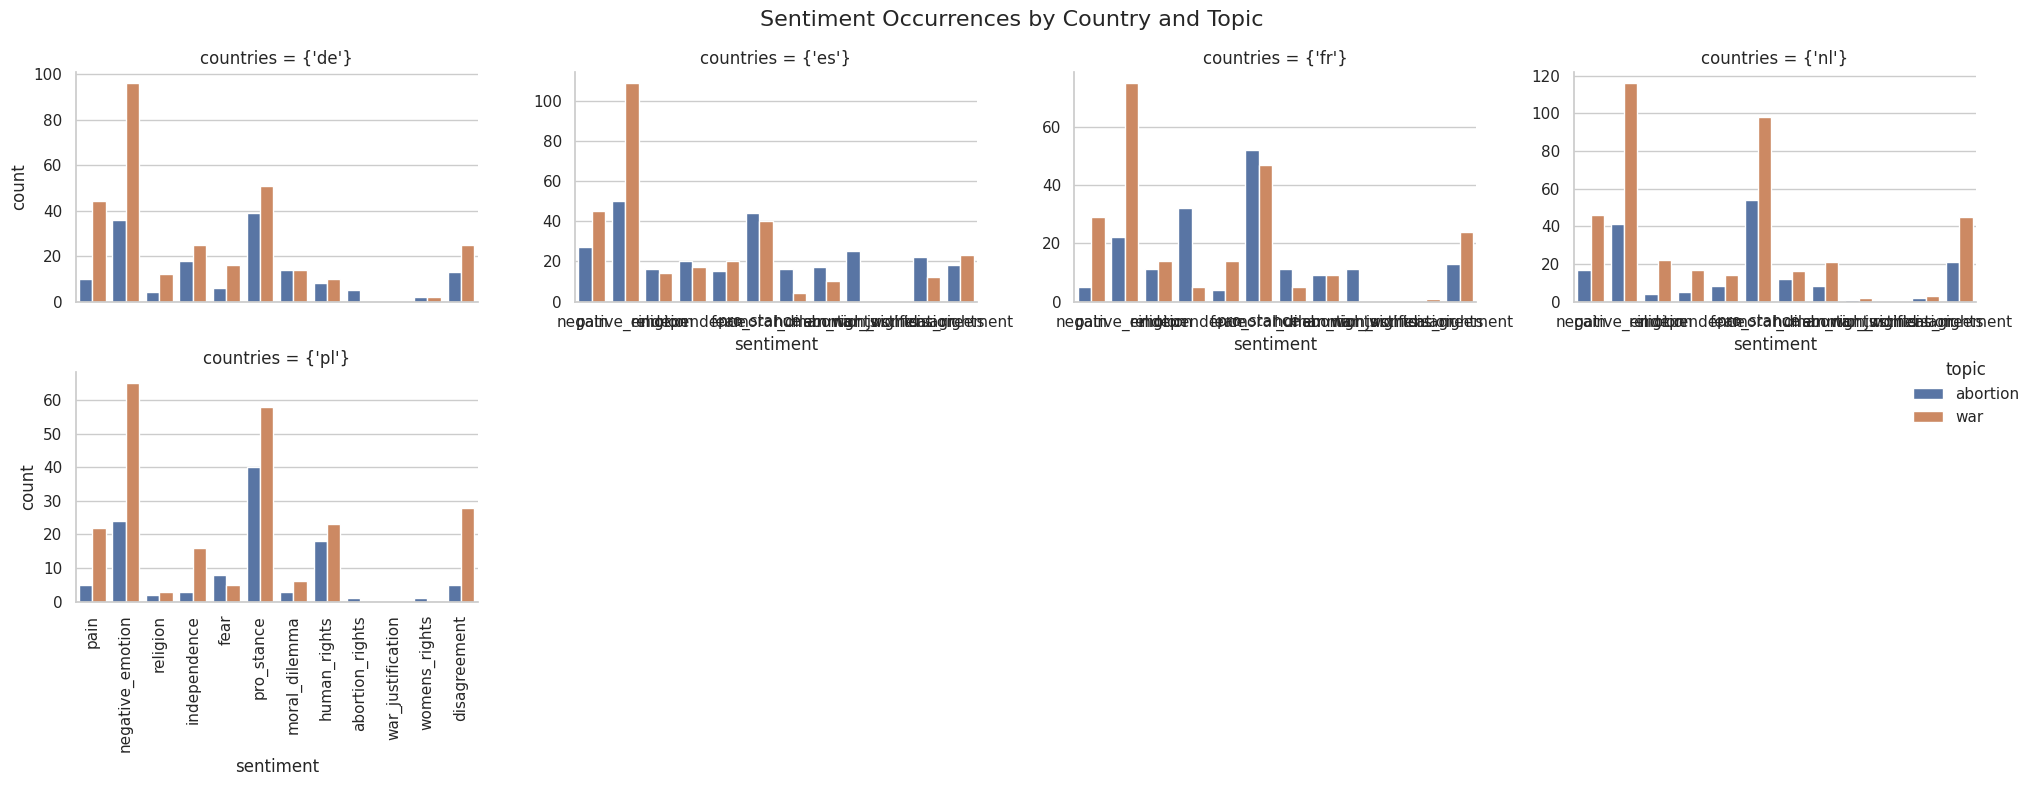

In [33]:
# Define sentiment columns
sentiment = [
    'pain', 'negative_emotion', 'religion',
    'independence', 'fear','pro_stance', 'moral_dilemma', 'human_rights',
    'abortion_rights', 'war_justification', 'womens_rights', 'disagreement'
]

# Count sentiment activations per (country, topic)
grouped_counts = (
    df.groupby(['countries', 'topic'])[sentiment]
    .apply(lambda g: (g > 0).sum())
    .reset_index()
)

# Reshape to long format for plotting
melted = grouped_counts.melt(id_vars=['countries', 'topic'], var_name='sentiment', value_name='count')

# Optional: filter to specific topics or countries if it's too dense
# melted = melted[melted['topic'].str.contains('abortion|war', case=False)]

# Plot: number of sentiment activations by country and topic
plt.figure(figsize=(18, 8))
sns.catplot(
    data=melted,
    x='sentiment',
    y='count',
    hue='topic',
    col='countries',
    kind='bar',
    col_wrap=4,
    height=4,
    aspect=1.2,
    sharey=False
)

plt.subplots_adjust(top=0.9)
plt.suptitle("Sentiment Occurrences by Country and Topic", fontsize=16)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


- **Conclusions of this part**

Most of the extremly negative content (-1) is on War, in all countries the War topic is the one that polarizes the most the tone while on most countries the abortion topic has mixed sentiments with a spike on 1 score.

While the % of positive entries (from 0.75 to 1) remains similar between the War and the Abortion-related content, abortion-related content tends to have a lower amount of extreme negative content than war (except on Spain and Germany on which it remains very similar, this could be due to having more anti-abort movements or for the way people is). 

I have seen that extreme (sentiment wise) content is very correlated to having positive content, meaning that the countries that are more neutral tend to use less positive vocabulary.

War evokes nearly the same amount of intense negative emotions accross countries being the most polarizating.

When analyzing individual sentiments, measuring intensity alone is not reliable due to the high frequency of zero values. However, by focusing on the number of appearances, clearer trends emerge. Negative sentiments such as pain, fear, and leader appear frequently across both topics.

Interestingly, both War and Abortion feature similar frequencies of leader, disagreement, government, and negative emotion marking how divisive both topics are. However, sentiments like pro stance, independence, and human rights appear more often in Abortion-related content, highlighting its moral and rights-based framing.

It is also notable that religion appears with similar frequency in both topics, despite Abortion being more commonly associated with religious debates.

- **WAR**
    - Strongly negative emotions
    - High polarization
- **ABORTION**
    - Mixed-Positive emotions
    - Moderated polarization

While Poland is the only country where the abortion is not fully accessible by women, it has barely mentions on topics like women_rights, independence or religion, meaning that maybe the conversations maybe are not that developed

# Political-Wing Analysis (Presence and topic relation)

- **% of right and left parties mentioned by country**

In [ ]:
mean_ideology = df.groupby('countries')[['% left', '% right']].mean().reset_index()
print(mean_ideology)

- **Relate the % of the wings mentioned with the mean sentiment score isolated by ideology**

In [ ]:
# Drop missing values
clean_df = df[['sentiment_score_compound', '% left', '% right']].dropna()

# Compute correlations
left_corr = clean_df['sentiment_score_compound'].corr(clean_df['% left'])
right_corr = clean_df['sentiment_score_compound'].corr(clean_df['% right'])

print(f"Correlation between sentiment score and % left: {left_corr:.3f}")
print(f"Correlation between sentiment score and % right: {right_corr:.3f}")


fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
# Left subplot: % Left
sns.regplot(data=clean_df, x='% left', y='sentiment_score_compound', ax=axes[0], scatter_kws={'s': 50}, line_kws={'color': 'purple'})
axes[0].set_title('Sentiment vs % Left')
axes[0].set_xlabel('% Left')
axes[0].set_ylabel('Sentiment Score')
axes[0].grid(True)

# Right subplot: % Right
sns.regplot(data=clean_df, x='% right', y='sentiment_score_compound', ax=axes[1], scatter_kws={'s': 50}, line_kws={'color': 'green'})
axes[1].set_title('Sentiment vs % Right')
axes[1].set_xlabel('% Right')
axes[1].grid(True)

plt.tight_layout()
plt.show()

- **Sentiment Score for Abortion content grouped by political wings**

In [ ]:
abortion_df = df[df['topic'].str.lower() == 'abortion']
abortion_clean = abortion_df[['sentiment_score_compound', '% right', '% left']].dropna()

# Compute correlations
corr_right = abortion_clean['sentiment_score_compound'].corr(abortion_clean['% right'])
corr_left = abortion_clean['sentiment_score_compound'].corr(abortion_clean['% left'])

print(f"Correlation between sentiment score and % right (abortion): {corr_right:.3f}")
print(f"Correlation between sentiment score and % left (abortion):  {corr_left:.3f}")

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot for % right
sns.regplot(data=abortion_clean, x='% right', y='sentiment_score_compound', ax=axes[0], scatter_kws={'s': 50}, line_kws={'color': 'red'})
axes[0].set_title('Sentiment Score vs % Right (Abortion)')
axes[0].set_xlabel('% Right')
axes[0].set_ylabel('Sentiment Score')
axes[0].grid(True)

# Plot for % left
sns.regplot(data=abortion_clean, x='% left', y='sentiment_score_compound', ax=axes[1], scatter_kws={'s': 50}, line_kws={'color': 'purple'})
axes[1].set_title('Sentiment Score vs % Left (Abortion)')
axes[1].set_xlabel('% Left')
axes[1].grid(True)

plt.tight_layout()
plt.show()


- **Sentiment Score for War content grouped by political wings**

In [ ]:
war_df = df[df['topic'].str.lower() == 'war']
war_clean = war_df[['sentiment_score_compound', '% right', '% left']].dropna()

# Compute correlations
corr_right = war_clean['sentiment_score_compound'].corr(war_clean['% right'])
corr_left = war_clean['sentiment_score_compound'].corr(war_clean['% left'])

print(f"Correlation between sentiment score and % right (war): {corr_right:.3f}")
print(f"Correlation between sentiment score and % left (war):  {corr_left:.3f}")

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot for % right
sns.regplot(data=war_clean, x='% right', y='sentiment_score_compound', ax=axes[0], scatter_kws={'s': 50}, line_kws={'color': 'red'})
axes[0].set_title('Sentiment Score vs % Right (War)')
axes[0].set_xlabel('% Right')
axes[0].set_ylabel('Sentiment Score')
axes[0].grid(True)

# Plot for % left
sns.regplot(data=war_clean, x='% left', y='sentiment_score_compound', ax=axes[1], scatter_kws={'s': 50}, line_kws={'color': 'purple'})
axes[1].set_title('Sentiment Score vs % Left (War)')
axes[1].set_xlabel('% Left')
axes[1].grid(True)

plt.tight_layout()
plt.show()

- **Most mentioned political entities by country**

In [ ]:
df['parties_mentioned'] = df['parties_mentioned'].apply(eval)

# Initialize result dictionary
top_parties_by_country = {}

# Loop through each country
for country in df['countries'].unique():
    country_df = df[df['countries'] == country]

    all_parties = sum(country_df['parties_mentioned'], [])  # flattens list of lists
    party_counts = Counter(all_parties)
    top_5 = party_counts.most_common(5)
    top_parties_by_country[country] = top_5

# Print results
for country, top_parties in top_parties_by_country.items():
    print(f"\nTop 5 parties in {country}:")
    for party, count in top_parties:
        print(f"  {party}: {count} mentions")

- **From which wing are the most mentioned parties?**

In [ ]:
left = [
    "Die Linke", "IU", "Podemos", "PCE", "PCF", "LFI", "PRC", "SI", "Syriza",
    "BE", "Vänsterpartiet", "Vasemmistoliitto", "AKEL", "PTB", "KPÖ",
    "SP", "Enhedslisten", "Rødt", "PST/POP", "PIE", "The Left", "Razem", "EFA",
    "S&D", "Renew Europe", "PSOE", "Sumar", "PES", "PS", "APSD", "SD", "SAP",
    "Labour", "SPÖ", "Vooruit", "SPD", "NL", "PvdA", "Socialist Party",
    "Democratic Party", "Labour", "PASOK", "SLD", "Nouvelle Donne", "PRG",
    "Inicjatywa Polska", "Grüne", "Greens"
]

right = [
    "EPP", "ECR", "PiS", "VOX", "ID", "RN", "Lega", "FPÖ", "Fidesz", "Patriots", 
    "ESN", "AfD", "Republika", "Reconquête", "NOWA NADZIEJA", "Mi Hazánk",
    "PP", "Partido Popular", "CDU", "Agir", "MoDem", "Ensemble", "LFA", "RE",
    "LR", "CDA", "NSC", "IDP", "CSU", "FDP", "FW", "Junts", "ZP", "NPD", "PVV",
    "FvD", "European People's Party", "Progressive Alliance of Socialists & Democrats"
]

In [ ]:
all_parties = sum(df['parties_mentioned'], [])  # flattens list of lists
party_counts = Counter(all_parties)

# Get the 20 most mentioned parties
top_20_parties = party_counts.most_common(20)

# Initialize dictionaries to store the country with the most mentions and the political wing
party_country_dict = {}
party_wing_dict = {}

# Loop through each country to find where each party was mentioned the most
for country in df['countries'].unique():
    country_df = df[df['countries'] == country]
    country_parties = sum(country_df['parties_mentioned'], [])
    country_party_counts = Counter(country_parties)
    
    for party in country_party_counts:
        # If the party is in the top 20, update the country with the most mentions for that party
        if party in dict(top_20_parties):
            if party not in party_country_dict or country_party_counts[party] > party_country_dict[party][1]:
                party_country_dict[party] = (country, country_party_counts[party])
                
                # Determine the political wing based on the lists
                if party in left:
                    party_wing_dict[party] = 'left'
                elif party in right:
                    party_wing_dict[party] = 'right'
                else:
                    party_wing_dict[party] = 'Unknown'  # If the party is not in either list

# Print the top 20 parties, their mentions, political wing, and the country that named them the most
print("Top 20 Most Mentioned Political Parties:")

for party, count in top_20_parties:
    most_mentioned_country, mentions_in_country = party_country_dict[party]
    political_wing = party_wing_dict.get(party, 'Unknown')  # Default to 'Unknown' if no wing found
    print(f"{party} ({political_wing}): {count} mentions, most mentioned in {most_mentioned_country} ({mentions_in_country} mentions)")

- **Conclusions of this part**

- **RIGHT**: 
    - This is the most frequently mentioned political wing overall. 
    - A higher %right is associated with a more diverse range of opinions. 
    - Right-leaning political parties are mentioned more often than others in all conutries.
    - The %right metric shows a slight negative correlation (-0.164) with the sentiment score. Mainly when refering to abortion (-0.233)

- **LEFT**: 
    - This category includes the most frequently mentioned political parties. 
    - Countries with a higher %left tend to be more polarized. 
    - %left is slightly positively correlated (0.137) with the sentiment score. Mainly when refering to abortion (0.219)

# Individual sentiments analysis

- **Correlation between sentiments**

In [ ]:
# Define the list of topics
topics = [
    'subjectivity_score', 'pain', 'movement', 'negative_emotion', 'religion',
    'violence', 'government', 'independence', 'fear', 'trust', 'leader',
    'pro_stance', 'moral_dilemma', 'misinformation', 'human_rights',
    'abortion_rights', 'womens_rights'
]

# Extract topic data from the DataFrame (make sure df is already defined)
topic_data = df[topics].dropna()

# Compute the correlation matrix
corr_matrix = topic_data.corr()

# Plot the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True,
            cbar_kws={"label": "Correlation Coefficient"})
plt.title("Correlation Matrix Between Topics")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Total number of entries per country and topic
total_counts = df.groupby(['countries', 'topic']).size().reset_index(name='total')

# Number of entries with pro_stance > 0
pro_stance_counts = df[df['pro_stance'] > 0].groupby(['countries', 'topic']).size().reset_index(name='pro_stance_positive')

merged = pd.merge(total_counts, pro_stance_counts, on=['countries', 'topic'], how='left')
merged['pro_stance_positive'] = merged['pro_stance_positive'].fillna(0)
merged['pro_stance_ratio'] = merged['pro_stance_positive'] / merged['total']

# Plotting
pivot_ratio = merged.pivot(index='countries', columns='topic', values='pro_stance_ratio')
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_ratio.fillna(0), annot=True, cmap='Greens', fmt=".2f", vmin=0, vmax=1)
plt.title("Ratio of Pro Stance Appearance by Country and Topic")
plt.xlabel("Topic")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

- **Top 5 sentiments by country**

In [ ]:
emotion_columns = [
    "negative_emotion", "fear", "trust", "pain", "movement", "religion", "violence",
    "government", "independence", "leader", "pro_stance", "moral_dilemma", "misinformation",
    "human_rights", "abortion_rights", "war_justification", "womens_rights"
]

def get_top_5_emotions(group):
    emotion_counts = (group[emotion_columns] > 0).sum()
    sorted_emotions = emotion_counts.sort_values(ascending=False)
    top_5_emotions = sorted_emotions.head(5)
    
    return pd.Series({
        'top_5_emotions': top_5_emotions.index.tolist(),
        'top_5_values': top_5_emotions.values.tolist()
    })

# Apply the function to group by country and topic
top_emotions = df.groupby(['countries', 'topic']).apply(get_top_5_emotions).reset_index()
top_emotions_table = top_emotions.pivot(index="countries", columns="topic", values="top_5_emotions")
top_emotions_table = top_emotions_table.applymap(lambda x: ", ".join(x))

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=top_emotions_table.values,
                rowLabels=top_emotions_table.index,
                colLabels=top_emotions_table.columns,
                loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.5, 1.5)
plt.title("Top 5 Emotions by Country and Topic")
plt.show()
